# Load Libraries

In [1]:
import os
import warnings
import logging
import sys
import pickle
import numpy as np
import pandas as pd
import geopandas as gpd
import dotenv

# Load environment variables from .env file
dotenv.load_dotenv()

# Set up logging
logging.basicConfig(level=logging.INFO)

# Suppress warnings
warnings.filterwarnings("ignore")

# Set display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_colwidth', None)

# Load Data

In [2]:
# Load Data From Pickle
with open('../../data/Data_Iran_1983_2022.pkl', 'rb') as f:
    data = pickle.load(f)
    logging.info("Data loaded from pickle file.")

INFO:root:Data loaded from pickle file.


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2454681 entries, 0 to 2454680
Data columns (total 17 columns):
 #   Column             Dtype         
---  ------             -----         
 0   station_id         category      
 1   station_name       category      
 2   region_id          category      
 3   region_name        category      
 4   lat                float64       
 5   lon                float64       
 6   station_elevation  float64       
 7   date               datetime64[ns]
 8   tmax               float64       
 9   tmin               float64       
 10  tm                 float64       
 11  umax               float64       
 12  umin               float64       
 13  um                 float64       
 14  ffm                float64       
 15  sshn               float64       
 16  rrr24              float64       
dtypes: category(4), datetime64[ns](1), float64(12)
memory usage: 257.5 MB


# Calculate ETo

In [4]:
import pyet


def calculate_eto(group):
    print(f"Calculating ETo for station {group.name}")
    group = group.set_index('date').sort_index()

    # --- Variable Checking and Cleaning ---
    # Remove duplicates
    group = group[~group.index.duplicated(keep='first')]
    # Drop rows with missing essential variables
    required_vars = ['tmax', 'tmin', 'tm', 'umin', 'umax', 'um', 'ffm', 'lat', 'station_elevation', 'sshn']
    group = group.dropna(subset=required_vars)
    # Clip or filter out physically impossible values (example thresholds, adjust as needed)
    group = group[(group['tm'] > -50) & (group['tm'] < 60)]
    group = group[(group['tmax'] > -50) & (group['tmax'] < 70)]
    group = group[(group['tmin'] > -60) & (group['tmin'] < 50)]
    group = group[(group['ffm'] >= 0) & (group['ffm'] < 50)]
    group = group[(group['umin'] >= 0) & (group['umin'] <= 100)]
    group = group[(group['umax'] >= 0) & (group['umax'] <= 100)]
    group = group[(group['um'] >= 0) & (group['um'] <= 100)]
    group = group[(group['sshn'] >= 0) & (group['sshn'] <= 24)]

    # If group is empty after cleaning, return NaNs
    if group.empty:
        return pd.Series(np.nan, index=group.index)

    tmean = group['tm']
    wind = group['ffm']
    lat = pyet.utils.deg_to_rad(lat=group['lat'].iloc[0])
    elevation = group['station_elevation'].iloc[0]
    rs = pyet.calc_rad_sol_in(n=group['sshn'], lat=lat, as1=0.25, bs1=0.5, nn=None)    
    tmax = group["tmax"]
    tmin = group["tmin"]
    rhmax = group["umin"]
    rhmin = group["umax"]
    rh = group["um"]
    # try:
    eto = pyet.calculate_all(
        tmean=tmean,
        wind=wind,
        rs=rs,
        elevation=elevation,
        lat=lat,
        tmax=tmax,
        tmin=tmin,
        rh=rh,
        rhmax=rhmax,
        rhmin=rhmin
    )
    return eto
    # except Exception as e:
    #     print(f"Error with simple method for station {group.name}: {e}")
    #     return pd.Series(np.nan, index=group.index)


eto_df = data.groupby(
    ['region_id', 'station_id'],
    group_keys=True
).apply(calculate_eto)

Calculating ETo for station ('ALKK', '40752')
Calculating ETo for station ('ALKK', '88125')
Calculating ETo for station ('ALKK', '88125')
Calculating ETo for station ('ALKK', '99321')
Calculating ETo for station ('ALKK', '99321')
Calculating ETo for station ('ALKK', '99373')
Calculating ETo for station ('ALKK', '99373')
Calculating ETo for station ('ALKK', '99396')
Calculating ETo for station ('ALKK', '99396')
Calculating ETo for station ('MAAA', '40769')
Calculating ETo for station ('MAAA', '40769')
Calculating ETo for station ('MAAA', '40891')
Calculating ETo for station ('MAAA', '40891')
Calculating ETo for station ('MAAA', '99372')
Calculating ETo for station ('MAAA', '99372')
Calculating ETo for station ('MAAA', '99398')
Calculating ETo for station ('MAAA', '99398')
Calculating ETo for station ('MAAA', '99409')
Calculating ETo for station ('MAAA', '99409')
Calculating ETo for station ('MAAA', '99410')
Calculating ETo for station ('MAAA', '99410')
Calculating ETo for station ('MAAA

In [9]:
# Join eto_df (with MultiIndex) back to data
# Reset index to align with data's index if needed
if isinstance(eto_df.index, pd.MultiIndex):
    eto_df = eto_df.reset_index()
    # Merge on region_id, station_id, and date
    data = pd.merge(data, eto_df, on=['region_id', 'station_id', 'date'], how='left')
else:
    data = data.join(eto_df)

data.head()

,station_id,station_name,region_id,region_name,lat,lon,station_elevation,date,tmax,tmin,tm,umax,umin,um,ffm,sshn,rrr24,Penman,FAO-56,Priestley-Taylor,Kimberly-Penman,Thom-Oliver,Blaney-Criddle,Hamon,Romanenko,Linacre,Haude,Turc,Jensen-Haise,Mcguinness-Bordne,Hargreaves,FAO-24,Abtew,Makkink,Oudin
0,40757,Semnan,OIIS,Semnan,35.59,53.42,1127.00,1983-01-01 12:00:00,8.40,-0.80,4.60,73.00,41.00,58.00,0.00,7.00,0.10,0.73,0.58,0.72,0.57,0.99,0.61,0.59,2.40,1.69,1.25,0.89,0.77,0.94,1.04,1.09,2.16,1.33,0.64
1,40757,Semnan,OIIS,Semnan,35.59,53.42,1127.00,1983-01-03 12:00:00,8.80,0.40,4.60,89.00,45.00,63.33,0.00,7.70,0.00,0.75,0.64,0.79,0.63,0.93,0.61,0.60,1.68,1.53,1.12,0.94,0.83,0.95,1.00,1.14,2.30,1.42,0.64
2,40757,Semnan,OIIS,Semnan,35.59,53.42,1127.00,1983-01-04 12:00:00,5.40,-1.00,1.70,67.00,51.00,60.00,0.00,8.20,0.00,0.69,0.55,0.67,0.54,0.94,0.33,0.50,2.01,1.08,0.97,0.42,0.53,0.66,0.76,1.09,2.39,1.34,0.45
3,40757,Semnan,OIIS,Semnan,35.59,53.42,1127.00,1983-01-05 12:00:00,4.80,-4.00,0.40,69.00,47.00,52.67,0.00,8.30,0.00,0.67,0.54,0.66,0.53,0.90,0.21,0.46,1.79,1.04,1.10,0.11,0.39,0.53,0.83,1.09,2.42,1.29,0.36
4,40757,Semnan,OIIS,Semnan,35.59,53.42,1127.00,1983-01-06 12:00:00,5.60,-3.20,1.80,68.00,39.00,49.17,0.50,8.00,0.00,0.75,0.75,0.69,0.58,0.98,0.35,0.51,2.17,1.31,1.25,0.45,0.54,0.68,0.90,1.19,2.37,1.33,0.46


In [16]:
# Fill missing dates for each station with NaN
all_dates = pd.date_range(data['date'].min(), data['date'].max(), freq='D')

def reindex_station(station_df):
    return station_df.set_index('date').reindex(all_dates).assign(
        region_id=station_df['region_id'].iloc[0],
        station_id=station_df['station_id'].iloc[0]
    ).reset_index().rename(columns={'index': 'date'})

data = (
    data.groupby(['region_id', 'station_id'], group_keys=False)
    .apply(reindex_station)
    .reset_index(drop=True)
)

data.head()

,date,station_id,station_name,region_id,region_name,lat,lon,station_elevation,tmax,tmin,tm,umax,umin,um,ffm,sshn,rrr24,Penman,FAO-56,Priestley-Taylor,Kimberly-Penman,Thom-Oliver,Blaney-Criddle,Hamon,Romanenko,Linacre,Haude,Turc,Jensen-Haise,Mcguinness-Bordne,Hargreaves,FAO-24,Abtew,Makkink,Oudin
0,1983-01-01 12:00:00,40752,NaN,ALKK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1983-01-02 12:00:00,40752,NaN,ALKK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1983-01-03 12:00:00,40752,NaN,ALKK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1983-01-04 12:00:00,40752,NaN,ALKK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1983-01-05 12:00:00,40752,NaN,ALKK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


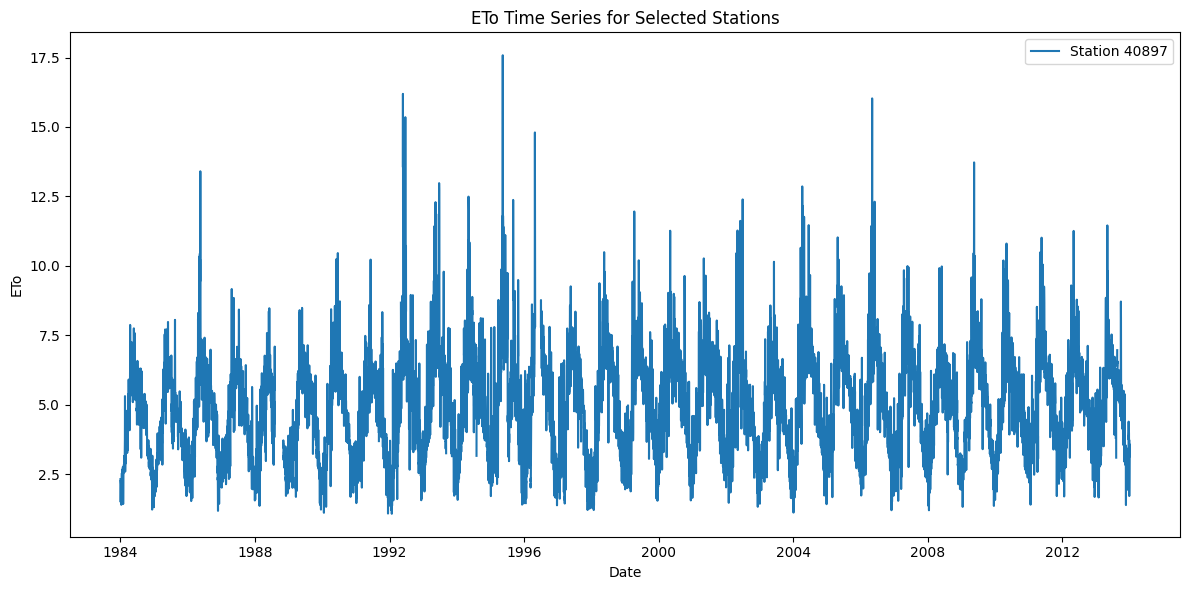

In [33]:
import matplotlib.pyplot as plt

# Select a few station_ids to plot (change as needed)
stations_to_plot = data['station_id'].drop_duplicates().sample(1)

plt.figure(figsize=(12, 6))
for sid in stations_to_plot:
    station_data = data[data['station_id'] == sid].sort_values('date')
    plt.plot(station_data['date'], station_data['FAO-56'], label=f'Station {sid}')

plt.xlabel('Date')
plt.ylabel('ETo')
plt.title('ETo Time Series for Selected Stations')
plt.legend()
plt.tight_layout()
plt.show()

# Export Data

In [ ]:
# # To pickle in data folder
# with open('../../Data/Data_Iran_1983_2022.pkl', 'wb') as f:
#     pickle.dump(df, f)